In [95]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
from glob import glob
from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.regularizers import l2
from os.path import join
from dask_jobqueue import PBSCluster
from dask.distributed import Client, progress
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:
cluster = PBSCluster(processes=18,
                     threads=4, memory="6GB",
                     project='NAML0001',
                     queue='premium',
                     resource_spec='select=1:ncpus=36:mem=60G',
                     walltime='03:00:00')
cluster.start_workers(10)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.148.8.43:57216 Dashboard: http://10.148.8.43:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
data_path = "/glade2/scratch2/cchen/archive/TAU_run1/atm/hist"
data_files = sorted(glob(data_path +"/TAU_run1.cam.h1*.nc"))
print(data_files)

['/glade2/scratch2/cchen/archive/TAU_run1/atm/hist/TAU_run1.cam.h1.0001-01-01-00000.nc', '/glade2/scratch2/cchen/archive/TAU_run1/atm/hist/TAU_run1.cam.h1.0001-06-03-64800.nc', '/glade2/scratch2/cchen/archive/TAU_run1/atm/hist/TAU_run1.cam.h1.0001-11-04-43200.nc', '/glade2/scratch2/cchen/archive/TAU_run1/atm/hist/TAU_run1.cam.h1.0002-04-07-21600.nc', '/glade2/scratch2/cchen/archive/TAU_run1/atm/hist/TAU_run1.cam.h1.0002-09-08-00000.nc']


## Input Variables
* RHO_CLUBB: air density (kg m-3)
* QC_TAU_in: cloud liquid mixing ratio (kg kg-1)
* NC_TAU_in: cloud liquid number concentration (kg-1)
* QR_TAU_in: rain mixing ratio (kg kg-1)
* NR_TAU_in: rain number concentration (kg-1)

## Output Variables
* autoconversion: 
    * prc_MG2: mass autoconversion rate in MG2 (kg kg-1 s-1)
    * nprc1_MG2: number autoconversion rate in MG2 (kg-1 s-1)
    * nprc_MG2: number autoconversion rate, fixed size for rain, in MG2 (kg-1 s-1)
* accretion:
    * pra_MG2: mass accretion rate in MG2 (kg kg-1 s-1)
    * npra_MG2: number accretion rate in MG2 (kg-1 s-1)
* self-collection:
    * nragg_MG2: number accretion rate in MG2 (kg-1 s-1)

In [8]:
ds = xr.open_mfdataset(data_files, decode_times=False)

In [26]:
ds.lev

<xarray.DataArray 'lev' (lev: 32)>
array([  3.643466,   7.59482 ,  14.356632,  24.61222 ,  35.92325 ,  43.19375 ,
        51.677499,  61.520498,  73.750958,  87.82123 , 103.317127, 121.547241,
       142.994039, 168.22508 , 197.908087, 232.828619, 273.910817, 322.241902,
       379.100904, 445.992574, 524.687175, 609.778695, 691.38943 , 763.404481,
       820.858369, 859.534767, 887.020249, 912.644547, 936.198398, 957.48548 ,
       976.325407, 992.556095])
Coordinates:
  * lev      (lev) float64 3.643 7.595 14.36 24.61 35.92 43.19 51.68 61.52 ...
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [29]:
rho = ds.RHO_CLUBB
rho_2 = xr.DataArray(0.5 * (rho[:, :-1].values + rho[:, 1:].values), coords=[ds.time, ds.lev, ds.lat, ds.lon], dims=("time", "lev", "lat", "lon"))
ds["RHO_CLUBB_lev"] = rho_2
print(rho)
print(rho_2.compute())

<xarray.DataArray 'RHO_CLUBB' (time: 143, ilev: 33, lat: 192, lon: 288)>
dask.array<shape=(143, 33, 192, 288), dtype=float32, chunksize=(30, 33, 192, 288)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 29.73 39.27 47.11 56.24 ...
  * time     (time) float64 0.0 5.125 10.25 15.38 20.5 25.62 30.75 35.88 ...
Attributes:
    mdims:      2
    units:      kg/m3
    long_name:  Air Density
<xarray.DataArray (time: 143, lev: 32, lat: 192, lon: 288)>
array([[[[0.007358, ..., 0.007358],
         ...,
         [0.008785, ..., 0.008785]],

        ...,

        [[0.976342, ..., 0.976342],
         ...,
         [1.429074, ..., 1.429074]]],


       ...,


       [[[0.007462, ..., 0.007462],
         ...,
         [0.009174, ..., 0.009174]],

        ...,

        [[0.948482, ..., 0.948482],
         ...,
         [1.392265,

In [33]:
ds["RHO_CLUBB_lev"].min()

<xarray.DataArray 'RHO_CLUBB_lev' ()>
array(0.007229)

In [9]:
print(np.count_nonzero((ds["pra_MG2"][1] > 0) & (ds["prc_MG2"][1] > 0)))
print(np.count_nonzero((ds["pra_MG2"][1] == 0) & (ds["prc_MG2"][1] > 0)))
print(np.count_nonzero((ds["pra_MG2"][1] > 0) & (ds["prc_MG2"][1] == 0)))
print(np.count_nonzero((ds["pra_MG2"][1] == 0) & (ds["prc_MG2"][1] == 0)))

print(np.count_nonzero((ds["pra_MG2"][1] < 0) | (ds["prc_MG2"][1] < 0)))

231449
4772
24796
1508455
0


(0, 1e-07)

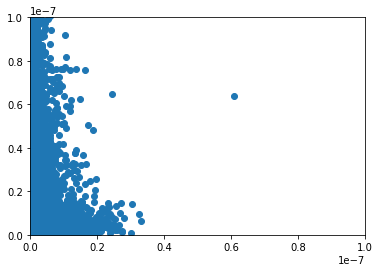

In [10]:
plt.scatter(ds["prc_MG2"][1].values.ravel(), ds["pra_MG2"][1].values.ravel())
plt.xlim(0, 1e-7)
plt.ylim(0, 1e-7)

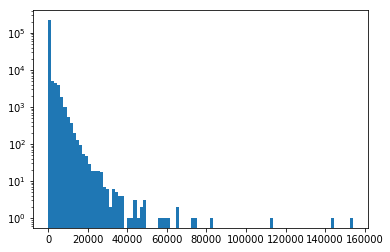

In [97]:
plt.hist(ds["nprc_MG2"][5].values[ds["nprc_MG2"][5] > 0], 100)
plt.gca().set_yscale("log")

In [35]:
cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev", "prc_MG2", "nprc1_MG2", "nprc_MG2", "pra_MG2", "npra_MG2"]
in_df = ds[cols].isel(lev=-1).to_dask_dataframe(dim_order=["time", "lat", "lon"], )
in_df_sub = in_df.loc[in_df["QC_TAU_in"] > 0].compute()


,time,lat,lon,lev,QC_TAU_in,NC_TAU_in,QR_TAU_in,NR_TAU_in,RHO_CLUBB_lev,prc_MG2,nprc1_MG2,nprc_MG2,pra_MG2,npra_MG2
605,0.00,-88.115183,36.25,992.556095,8.077936e-28,1.188733e+01,7.470971e-11,1.449457e+00,0.975612,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
611,0.00,-88.115183,43.75,992.556095,4.038968e-28,8.544121e+00,7.108500e-11,1.161728e+00,0.971111,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
613,0.00,-88.115183,46.25,992.556095,4.038968e-28,8.785646e+00,4.533217e-11,8.096051e-01,0.969698,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
614,0.00,-88.115183,47.50,992.556095,4.038968e-28,8.060197e+00,2.743556e-11,4.959186e-01,0.969017,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
617,0.00,-88.115183,51.25,992.556095,1.009742e-28,4.618555e+00,4.676030e-13,7.182703e-03,0.967076,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
619,0.00,-88.115183,53.75,992.556095,1.972152e-31,2.602477e-01,1.158085e-24,1.000000e-12,0.965882,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
892,0.00,-87.172775,35.00,992.556095,3.231174e-27,1.964618e+01,1.213756e-10,2.514512e+00,0.972283,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
894,0.00,-87.172775,37.50,992.556095,3.231174e-27,2.457674e+01,5.001474e-10,9.849887e+00,0.970045,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
908,0.00,-87.172775,55.00,992.556095,2.019484e-28,7.030274e+00,6.445941e-13,1.202645e-02,0.957435,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
1185,0.00,-86.230366,41.25,992.556095,3.231174e-27,2.044247e+01,8.539815e-11,1.671159e+00,0.958765,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000


In [41]:
in_df_sub["QC_TAU_in"].max().compute()

0.0017801817739382386

In [42]:
in_df_sub.to_csv("/glade2/work/dgagne/cam_mp_csv/cam_mp_*.csv")

['/glade2/work/dgagne/cam_mp_csv/cam_mp_0.csv',
 '/glade2/work/dgagne/cam_mp_csv/cam_mp_1.csv',
 '/glade2/work/dgagne/cam_mp_csv/cam_mp_2.csv',
 '/glade2/work/dgagne/cam_mp_csv/cam_mp_3.csv',
 '/glade2/work/dgagne/cam_mp_csv/cam_mp_4.csv']

In [45]:
mp_csv_data = []
csv_path = "/glade2/work/dgagne/cam_mp_csv"
for i in range(5):
    mp_csv_data.append(pd.read_csv(join(csv_path, "cam_mp_{0:d}.csv".format(i)), index_col=0))
mp_data = pd.concat(mp_csv_data)

In [108]:
min_max_mp = MinMaxScaler()
mp_scaled = pd.DataFrame(min_max_mp.fit_transform(np.sqrt(mp_data[input_cols + output_cols])), 
                         index=mp_data.index, columns=[input_cols + output_cols])

In [62]:
shuffled_indices = np.random.permutation(mp_scaled.index.values)
split = int(0.7 * len(shuffled_indices))
train_indices = shuffled_indices[:split]
test_indices = shuffled_indices[split:]

In [64]:
input_cols = ['QC_TAU_in', 'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in', 'RHO_CLUBB_lev']
output_cols = ['prc_MG2', 'nprc1_MG2', 'nprc_MG2', 'pra_MG2', 'npra_MG2']

In [119]:
mp_in = Input(shape=(len(input_cols),))
mp_mod = Dense(64, kernel_regularizer=l2(0.00001))(mp_in)
mp_mod = Activation("relu")(mp_mod)
mp_mod = Dense(64, kernel_regularizer=l2(0.00001))(mp_mod)
mp_mod = Activation("relu")(mp_mod)
mp_mod = Dense(len(output_cols))(mp_mod)
mp_model = Model(mp_in, mp_mod)
mp_model.compile(optimizer="adam", loss="mse")
mp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                384       
_________________________________________________________________
activation_37 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
activation_38 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 325       
Total params: 4,869
Trainable params: 4,869
Non-trainable params: 0
_________________________________________________________________


In [120]:
fit_hist = mp_model.fit(mp_scaled.loc[train_indices, input_cols], 
                        mp_scaled.loc[train_indices, output_cols], batch_size=2048, epochs=15, verbose=2)

Epoch 1/15
 - 4s - loss: 5.6295e-04
Epoch 2/15
 - 3s - loss: 2.1745e-04
Epoch 3/15
 - 3s - loss: 1.5603e-04
Epoch 4/15
 - 3s - loss: 1.2428e-04
Epoch 5/15
 - 3s - loss: 1.0596e-04
Epoch 6/15
 - 3s - loss: 9.4635e-05
Epoch 7/15
 - 3s - loss: 8.7271e-05
Epoch 8/15
 - 3s - loss: 8.2605e-05
Epoch 9/15
 - 3s - loss: 7.8950e-05
Epoch 10/15
 - 3s - loss: 7.6085e-05
Epoch 11/15
 - 3s - loss: 7.4088e-05
Epoch 12/15
 - 3s - loss: 7.2088e-05
Epoch 13/15
 - 3s - loss: 7.0465e-05
Epoch 14/15
 - 3s - loss: 6.9050e-05
Epoch 15/15
 - 3s - loss: 6.7804e-05


In [121]:
mp_preds = mp_model.predict(mp_scaled.loc[test_indices, input_cols])

In [123]:
mp_preds.min()

-0.028610721

In [134]:
mp_scaled.loc[test_indices, output_cols[a]].values

array([[0.        ],
       [0.        ],
       [0.02879968],
       ...,
       [0.10836479],
       [0.        ],
       [0.        ]])

In [135]:
np.corrcoef(mp_preds[:, a], 
            mp_scaled.loc[test_indices, output_cols[a]].values.ravel())

array([[1.       , 0.9860876],
       [0.9860876, 1.       ]])

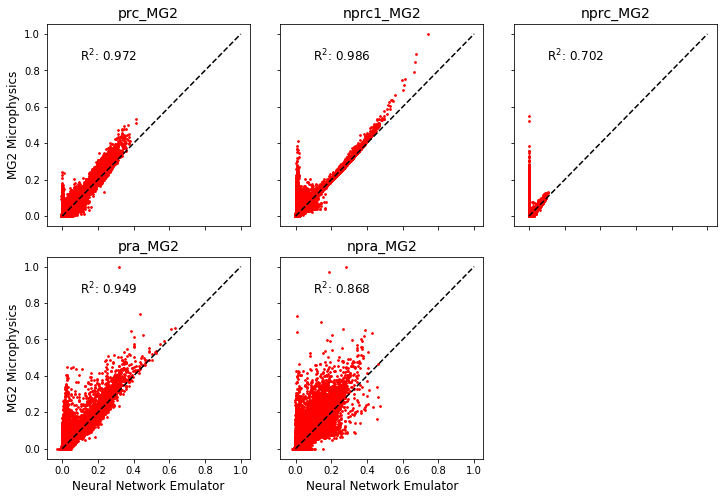

In [138]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.15, wspace=0.15)
for a, ax in enumerate(axes.ravel()):
    if a < len(output_cols):
        ax.scatter(mp_preds[:, a], mp_scaled.loc[test_indices, output_cols[a]], 3, "r")
        ax.plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), 'k--')
        ax.text(0.1, 0.85, "R$^2$: {0:0.3f}".format(np.corrcoef(mp_preds[:, a], 
                                                               mp_scaled.loc[test_indices, output_cols[a]].values.ravel())[0, 1] ** 2),
               fontsize=12)
        ax.set_title(output_cols[a], fontsize=14)
    else:
        ax.remove()
    if a > 2:
        ax.set_xlabel("Neural Network Emulator", fontsize=12)
    if a % 3 == 0:
        ax.set_ylabel("MG2 Microphysics", fontsize=12)
plt.savefig("nn_error_scatter.png", dpi=200, bbox_inches="tight")

In [29]:
qc = ds["QC_TAU_in"][20]

In [10]:
ds["QC_TAU_in"]

<xarray.DataArray 'QC_TAU_in' (time: 143, lev: 32, lat: 192, lon: 288)>
dask.array<shape=(143, 32, 192, 288), dtype=float32, chunksize=(30, 32, 192, 288)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * lev      (lev) float64 3.643 7.595 14.36 24.61 35.92 43.19 51.68 61.52 ...
  * time     (time) float64 0.0 5.125 10.25 15.38 20.5 25.62 30.75 35.88 ...
Attributes:
    mdims:      1
    units:      kg/kg
    long_name:  qc in TAU

In [35]:
ds["time"].size

143

In [37]:
qc_nz_counts = np.zeros((ds["time"].size, ds["lev"].size, ds["lat"].size))
for t in range(qc_nz_counts.shape[0]):
    qc_nz_counts[t] = np.sum(ds["QC_TAU_in"][t] > 0, axis=2)

Text(0.5,0,'Latitude (degrees)')

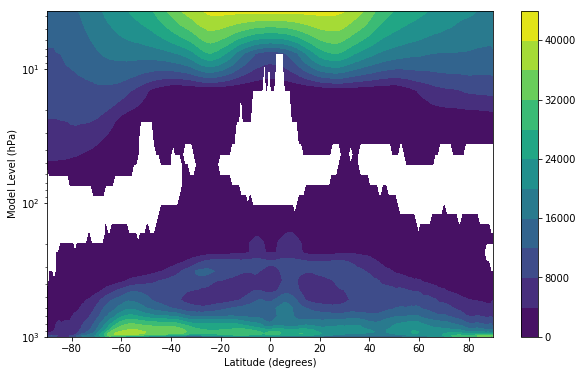

In [75]:
plt.figure(figsize=(10, 6))
lat_lev_cross = qc_nz_counts.sum(axis=0)
plt.contourf(ds["lat"], ds["lev"], np.ma.array(lat_lev_cross, mask=lat_lev_cross==0), 10, vmin=1)
plt.colorbar()
plt.gca().set_yscale("log")
plt.gca().invert_yaxis()
plt.ylabel("Model Level (hPa)")
plt.xlabel("Latitude (degrees)")

Text(0.5,0,'Latitude (degrees)')

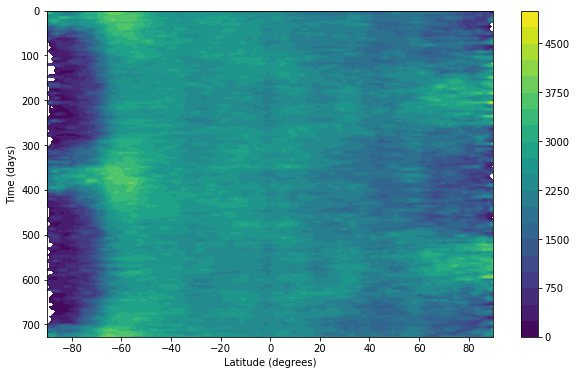

In [77]:
plt.figure(figsize=(10, 6))
lat_time_cross = qc_nz_counts.sum(axis=1)
plt.contourf(ds["lat"], ds["time"], np.ma.array(lat_time_cross, mask=lat_time_cross==0), 20, vmin=1)
plt.colorbar()
plt.gca().invert_yaxis()
plt.ylabel("Time (days)")
plt.xlabel("Latitude (degrees)")

Text(0,0.5,'Level (hPa)')

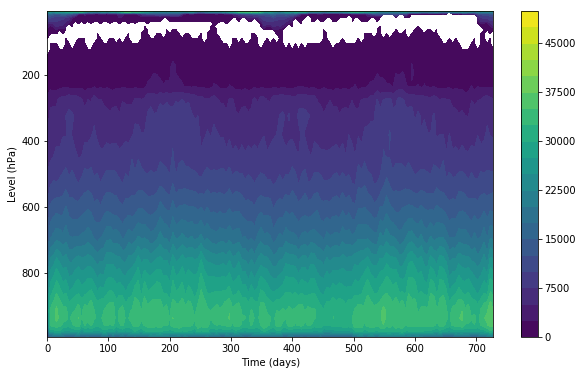

In [79]:
plt.figure(figsize=(10, 6))
time_lev_cross = qc_nz_counts.sum(axis=2)
plt.contourf(ds["time"], ds["lev"], np.ma.array(time_lev_cross, mask=time_lev_cross==0).T, 20, vmin=1)
plt.colorbar()
#plt.gca().set_yscale("log")
plt.gca().invert_yaxis()
plt.xlabel("Time (days)")
plt.ylabel("Level (hPa)")

In [30]:
np.count_nonzero(qc.values > 0) / qc.values.size

0.2273220486111111

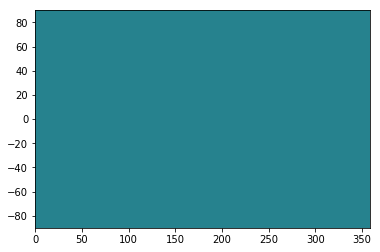

In [23]:
plt.contourf(qc["lon"], qc["lat"], qc[10])

In [7]:
np.sqrt(qc[qc >0] * 1000).max()

IndexError: 3-dimensional boolean indexing is not supported. 

(array([1.399790e+05, 1.241370e+05, 1.183730e+05, 1.282220e+05,
        1.596870e+05, 1.995610e+05, 2.300150e+05, 2.462710e+05,
        2.077910e+05, 2.353000e+05, 2.506310e+05, 2.531980e+05,
        1.946670e+05, 1.211610e+05, 9.692000e+04, 1.094290e+05,
        1.079160e+05, 1.182570e+05, 1.223530e+05, 1.385670e+05,
        1.536520e+05, 1.912320e+05, 1.655210e+05, 1.810880e+05,
        1.895180e+05, 2.164350e+05, 2.783480e+05, 3.921360e+05,
        3.130790e+05, 2.630480e+05, 3.496850e+05, 2.784950e+05,
        2.559870e+05, 2.321220e+05, 2.307190e+05, 2.671110e+05,
        3.007760e+05, 3.710400e+05, 3.886680e+05, 4.099410e+05,
        4.890260e+05, 6.736410e+05, 1.043651e+06, 1.491868e+06,
        6.474730e+05, 1.792300e+05, 1.787280e+05, 1.889260e+05,
        2.010020e+05, 2.153680e+05, 2.382600e+05, 2.653740e+05,
        3.124260e+05, 3.629700e+05, 3.595380e+05, 2.723320e+05,
        1.828150e+05, 1.596040e+05, 1.471360e+05, 1.391820e+05,
        1.336430e+05, 1.300910e+05, 1.32

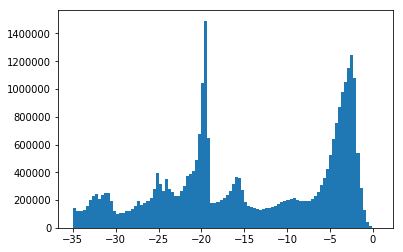

In [114]:
plt.hist(np.log10(qc[qc >0] * 1000), 100)

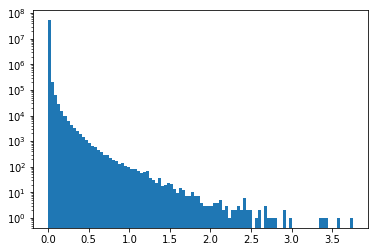

In [115]:
plt.hist(qc.ravel() * 1000, 100)
plt.gca().set_yscale("log")

/glade/u/home/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/contour.py:1484: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


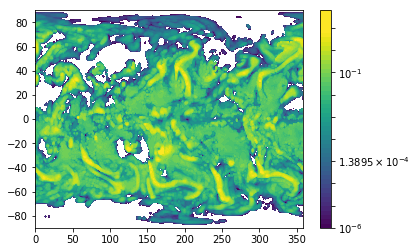

In [111]:
plt.contourf(ds["lon"], ds["lat"], ds["QR_TAU_in"][15].sum(axis=0)* 1000,
             np.logspace(-6, 1), norm=LogNorm(vmin=1e-6, vmax=2))
plt.colorbar()

In [91]:
ds

<xarray.Dataset>
Dimensions:       (ilev: 33, lat: 192, lev: 32, lon: 288, nbnd: 2, time: 30)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 ...
  * lon           (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 35.92 43.19 51.68 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 29.73 39.27 47.11 ...
  * time          (time) object    1-01-01 00:00:00    1-01-06 03:00:00 ...
Dimensions without coordinates: nbnd
Data variables:
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    date          (time) int32 10101 10106 10111 10116 10121 10126 10131 ...
    datesec       (time) int32 0 10800 21600 32400 43200 54000 64800 75600 0 ...
    time_bnds     (time, nbnd) float64 ...
    date_written  (time) |S8 ...
    tim

In [100]:
ds["QC_TAU_in"][10, :, :, 25].values.shape

(32, 192)

In [97]:
ds["QC_TAU_in"][10, :, :, 25]

<xarray.DataArray 'QC_TAU_in' (lev: 32, lat: 192)>
array([[9.973102e-23, 9.981803e-23, 9.977993e-23, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [2.429027e-23, 2.421477e-23, 2.392284e-23, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 6.926727e-09, 6.029328e-09, ..., 2.695635e-05,
        2.391288e-05, 6.688506e-06],
       [0.000000e+00, 4.685203e-26, 2.769185e-08, ..., 2.929238e-05,
        2.265059e-05, 8.820642e-06],
       [0.000000e+00, 0.000000e+00, 3.364949e-18, ..., 5.034522e-06,
        9.487872e-07, 5.293956e-23]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
    lon      float64 31.25
  * lev      (lev) float64 3.643 7.595 14.36 24.61 35.92 43.19 51.68 61.52 ...
    time     object    1-02-21 06:00:00
Attributes:
    mdims:      1
    units:      k

In [102]:
ds["lev"].values.shape

(32,)

In [103]:
ds["lat"].values.shape

(192,)

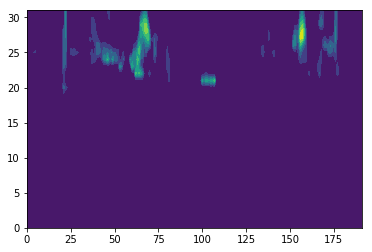

In [109]:
plt.contourf(ds["QC_TAU_in"][10, :, :, 25].values)

In [26]:
ds["ilev"]

<xarray.DataArray 'ilev' (ilev: 33)>
array([   2.25524 ,    5.031692,   10.157947,   18.555317,   29.734676,
         39.273001,   47.114499,   56.240499,   66.800497,   80.701418,
         94.941042,  111.693211,  131.401271,  154.586807,  181.863353,
        213.952821,  251.704417,  296.117216,  348.366588,  409.835219,
        482.149929,  567.224421,  652.332969,  730.445892,  796.363071,
        845.353667,  873.715866,  900.324631,  924.964462,  947.432335,
        967.538625,  985.11219 , 1000.      ])
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 29.73 39.27 47.11 56.24 ...
Attributes:
    long_name:      hybrid level at interfaces (1000*(A+B))
    units:          hPa
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyai b: hybi p0: P0 ps: PS